# **FRA501-HW3 Report**
Authors
- 64340500035 Napassorn Techasombooranakit
- 64340500049 Wasupol Hengsritawat

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

## **Chapter 1: Hello Soft Clustering (GMM)**

Recall from HW1 we did K-means clustering. Fitting a GMM on a set of points can be considered as 
another method to do clustering but now with soft assignments. Consider the same set of points we 
used in HW1.

<div align="center">

|  x |  y |
|:--:|:--:|
|  1 |  2 |
|  3 |  3 |
|  2 |  2 |
|  8 |  8 |
|  6 |  6 |
|  7 |  7 |
| -3 | -3 |
| -2 | -4 |
| -7 | -7 |

</div>

In class, we showed  that we could fit a GMM on 1-dimensional data by using Expectation 
Maximization  (EM). The algorithm for doing EM on N-dimensional GMM is very similar.  The exact 
algorithm is as follows: 

&nbsp;&nbsp;&nbsp;&nbsp;**Initialization**: Initialize the mixture weights, $\phi =𝑚_𝑗$, where $𝑗$ is the mixture number, means 
of each Gaussian $\vec{\mu}_j$ (now a vector of $N$ dimensions), and covariance matrices of each Gaussian, $\bold\Sigma_𝑗$. 

&nbsp;&nbsp;&nbsp;&nbsp;**Expectation**:  Find  the  soft  assignments  for  each  data  point where  $n$  corresponds  to  the 
sample index. 
$$w_{n,j}=\frac{p(x_n;\vec{\mu}_j,\bold\Sigma_j)m_j}{\sum_jp(x_n;\vec{\mu}_j,\bold\Sigma_j)m_j}$$ 
&nbsp;&nbsp;&nbsp;&nbsp;$w_{n,j}$ means the probability that data point 𝑛 comes from Gaussian number. 

>**Note**: For the generalized Gaussian is then given by 
>$$P(\vec{x};\vec{\mu},\bold\Sigma)=\frac{1}{\sqrt{(2\pi)^k|\bold\Sigma|}}exp(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\bold\Sigma^{-1}(\vec{x}-\vec{\mu}))$$
>where $k$ is the number of variables and $|\bold\Sigma|$ is the determinant of $\bold\Sigma$. 
>The  above  equation  is  used  for  full  covariance  matrices. For  our  example,  we  will  use diagonal covariance matrices, which can be acquired by setting the off-diagonal values to 
zero.  In other words, $\Sigma_{(i,j)}=0$, for $i\neq j$. 

&nbsp;&nbsp;&nbsp;&nbsp;**Maximization**: Update the model parameters $\phi$, $\vec{\mu}_j$, $\bold\Sigma_j$.
$$ 
\begin{align*}
m_j &= \frac{1}{N}\sum_n w_{n,j}\\
\vec{\mu}_j &= \frac{\sum_n w_{n,j}\vec{x}_n}{\sum_n w_{n,j}}\\
\bold\Sigma_j &= \frac{\sum_n w_{n,j}(\vec{x}-\vec{\mu})(\vec{x}-\vec{\mu})^T}{\sum_n w_{n,j}}
\end{align*}
$$

Given the data

In [2]:
data_1 = np.array([[1, 3, 2, 8, 6, 7, -3, -2, -7],
                   [2, 3, 2, 8, 6, 7, -3, -4, -7]])
print(data_1)

[[ 1  3  2  8  6  7 -3 -2 -7]
 [ 2  3  2  8  6  7 -3 -4 -7]]


### 1. Using 3 mixtures, initialize your Gaussian with means (3,3), (2,2),  and (-3,-3), and standard Covariance,  $\bold{I}$,  the  identity  matrix. Use  equal  mixture  weights  as  the  initial  weights.  Repeat  three iterations of EM. Write down $w_{n,j}$, $m_j$, $\vec{\mu}_j$, $\bold\Sigma_j$. and plot the likelihood distributions (3 Gaussians) of each feature for each EM iteration. 

First, lets defined function which returns probability (likelihhood) according to the normal distribution.

In [3]:
def multivariate_normal(x: np.ndarray, mean: np.ndarray, cov: np.ndarray)->float:
    return np.exp((-0.5*np.array([x - mean])@np.linalg.inv(cov)@np.transpose([x - mean]))[0][0])/(np.sqrt(((2*np.pi)**len(mean))*np.linalg.det(cov)))

def normal(x: float, mean: float, var: float):
    return (np.exp(-(x-mean)**2/(2*var)))/(np.sqrt(2*np.pi*var))

This section will be divided into two parts: EM using a regular covariance matrix to observe how the general EM algorithm can fit the Gaussian mixture model, and EM using a diagonal matrix as instructed.

#### Display functions

The functions which will be used to visualization the results in each iteration are defined below.

In [4]:
# Access matplotlib.pyplot default colors cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def hex2rgb(hex):
    '''Convert hex color code to rgb'''
    rgb = []
    for i in (0, 2, 4):
        decimal = int(hex[i:i+2], 16)
        rgb.append(decimal)
    
    return np.array(rgb, dtype='int')

def rgb2hex(r, g, b):
    '''Convert rgb to hex color code'''
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def gmm_contour_plot(data, mean, cov, res):
    '''Plot data onto 2D-plane, then draws contour according normal distribution with given parameters.'''
    # -- |Domain Initialization| --
    x = np.linspace(min(data[0]), max(data[0]), res)
    y = np.linspace(min(data[1]), max(data[1]), res)
    X, Y = np.meshgrid(x, y) 

    try: 
        # -- |Probability Calculation| --
        for j in range(len(mean)):
            Z_j = []
            for row in range(len(X)):
                Z_row = []
                for col in range(len(X[0])):
                    Z_row.append(multivariate_normal(np.array([X[row][col],Y[row][col]]),mean[j],cov[j]))
                Z_j.append(Z_row)

            # Plot contour map according to calculated probability
            plt.contour(X,Y,Z_j,colors = colors[j],alpha=0.2)

        # -- |Data Plot| --
        for n in range(data.shape[1]):
            w_color = []
            c = np.zeros(3)

            # Determine the color which represent each data interpreted labels
            for j in range(len(mean)):
                w_color.append(multivariate_normal(data.T[n],mean[j],cov[j]))
            w_color = w_color/np.sum(w_color)
            for j in range(len(mean)):
                c += w_color[j]*hex2rgb(colors[j][1:])
            c = c.astype('int')

            plt.plot(data[0][n],data[1][n],'o',color=rgb2hex(c[0],c[1],c[2]))
    
    except Exception as e: print('Error:', e)

def gmm_proj_plot(data, mean, cov, m, res):
    '''Plot data onto 1D-axis which represents each features, then draw the projected distribution onto each axis given the parameters.'''
    fig, ax = plt.subplots(1, data.shape[0])
    fig.set_figwidth(15)

    try:
        for p in range(data.shape[0]):  # Iteration over features
            # -- |Domain Initialization| --
            x = np.linspace(min(data[p]), max(data[p]), res)

            # -- |Distribution Plot| --
            legends = []
            Z_x = []
            for j in range(len(mean)):
                Z_xj = []
                for dx in x:
                    Z_xj.append(normal(dx, mean[j][p], cov[j][p][p]))
                Z_x.append(Z_xj)
                legends.append(f'Distribution {j+1}')
                ax[p].plot(x,Z_xj)

            # -- |GMM Distribution Plot| --
            Z_gmm = []
            for i in range(len(x)):
                mixture = 0
                for j in range(len(mean)):
                    mixture += m[j] * Z_x[j][i]
                Z_gmm.append(mixture)
            ax[p].plot(x,Z_gmm, alpha = 0.3)
            legends.append('GMM')
            ax[p].legend(legends)
                
            # -- |Data Plot| --
            for n in range(data.shape[1]):
                w_color = []
                c = np.zeros(3)

                # Determine the color which represent each data interpreted labels
                for j in range(len(mean)):
                    w_color.append(multivariate_normal(data.T[n],mean[j],cov[j]))
                w_color = w_color/np.sum(w_color)
                for j in range(len(mean)):
                    c += w_color[j]*hex2rgb(colors[j][1:])
                c = c.astype('int')

                ax[p].plot(data[p][n],0,'o',color=rgb2hex(c[0],c[1],c[2]))

            ax[p].set_ylim((-0.02, 0.5))
            ax[p].grid(True)

        ax[0].set_title('X')
        ax[1].set_title('Y')
        plt.show()
        
    except Exception as e: print('Error:', e)

#### Initial Parameters

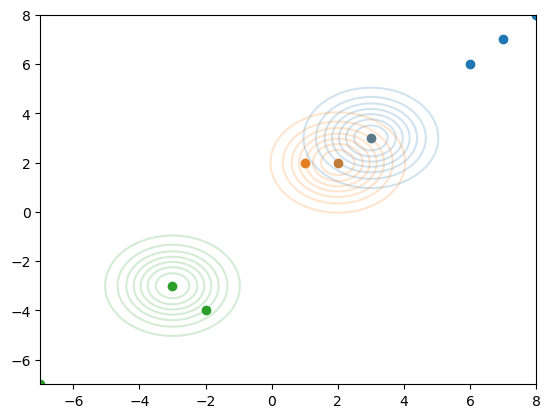

In [5]:
# -- |Parameters Initialization| --
m = np.full(3, 1/3)                         # Mixture weight [size: K]
mean = np.array([[3,3],[2,2],[-3,-3]])      # Mean [size: K x D]
cov = np.full((3,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

gmm_contour_plot(data_1,mean,cov,res = 800)

#### **1.1  Regular Covariance Matrix**

The function which perform one iteration of general EM algorithm is defined as

In [6]:
def one_EM_iteration_regular_cov():
    # -- |Expectation-step| --
    w = []  # weight [size: K x N]

    # Iteration over all instances
    for n in range(data_1.shape[1]):
    # At instance x_n
        denom = 0   # denominator (marginal probability of x = x_n)
        w_n = []    # weight at x_n [size: K] (probability that x_n will be classified as class j)

        # denominator calculation
        for j in range(len(mean)):
            denom += multivariate_normal(data_1.T[n], mean[j], cov[j])*m[j]

        # weight calculation for every possible classes
        for j in range(len(mean)):
            w_n.append(multivariate_normal(data_1.T[n], mean[j], cov[j])*m[j]/denom)

        w.append(w_n)

    w = np.transpose(w)   

    # -- |Maximization-step| --
    for j in range(len(mean)):
        w_sum = 0   # Summation of weights belong to each class
        wx_sum = 0  # Summation of weights belong to each class times data
        gram_sum = 0

        for n in range(data_1.shape[1]):
            w_sum += w[j][n]
            wx_sum += w[j][n] * data_1.T[n]
        
        # Update mixture weight
        m[j] = w_sum/data_1.shape[1]

        # Update mean
        mean[j] = wx_sum/w_sum

        # Update covariance
        for n in range(data_1.shape[1]):
            gram_sum += w[j][n] * np.transpose([data_1.T[n] - mean[j]]) @ [data_1.T[n] - mean[j]]
        cov[j] = gram_sum/w_sum

##### **1st Iteration**

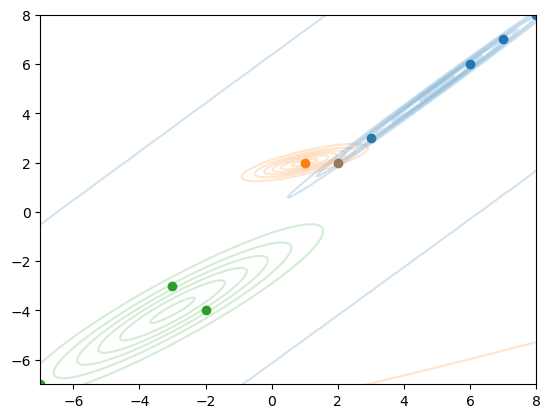

In [7]:
one_EM_iteration_regular_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

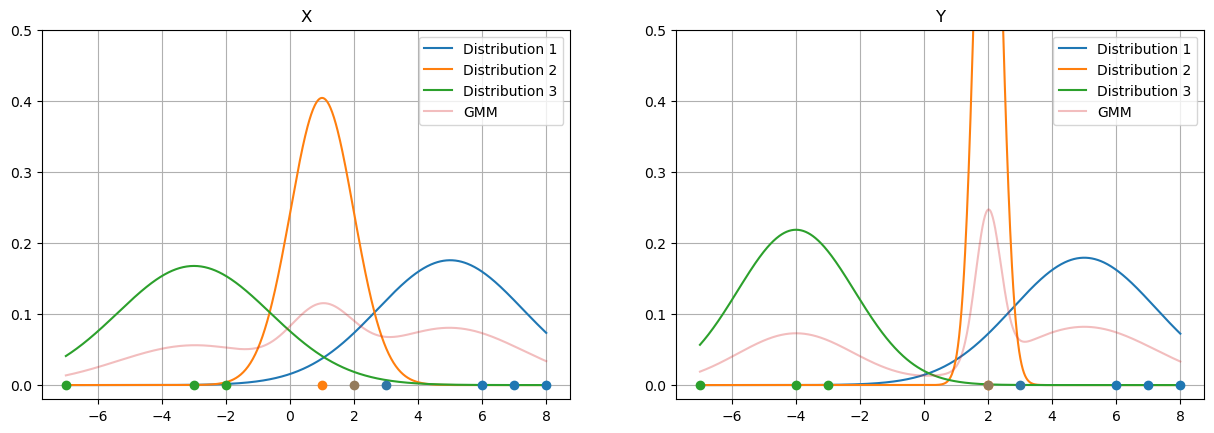

In [8]:
gmm_proj_plot(data_1,mean,cov,m,res = 800)

##### **2nd Iteration**

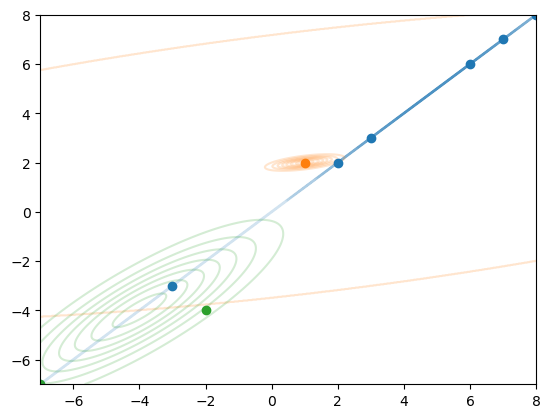

In [9]:
one_EM_iteration_regular_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

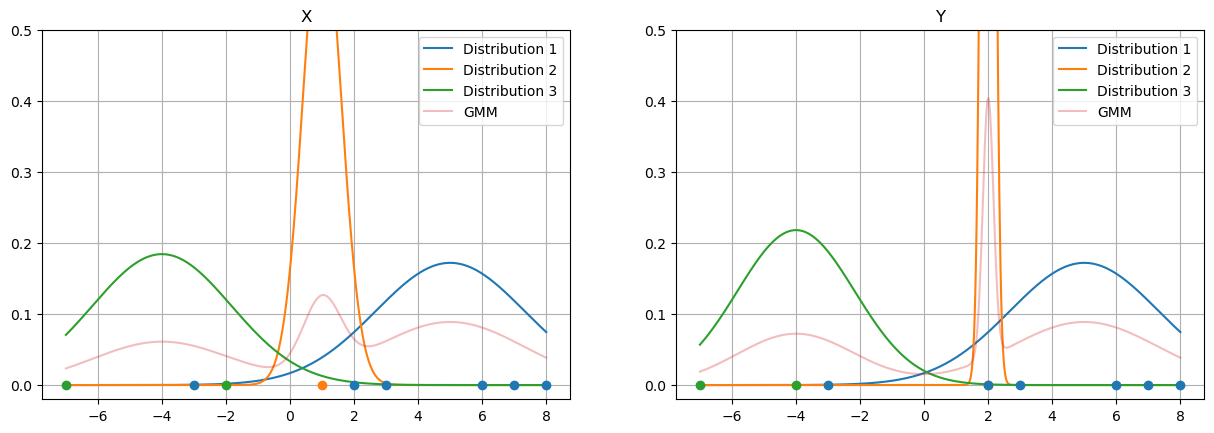

In [10]:
gmm_proj_plot(data_1,mean,cov,m,res = 800)

##### **3rd Iteration**

In [11]:
one_EM_iteration_regular_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

Error: Singular matrix


In [12]:
cov

array([[[1.55281858e+01, 1.55281858e+01],
        [1.55281858e+01, 1.55281858e+01]],

       [[2.45593012e-04, 3.62332274e-11],
        [3.62332274e-11, 1.81166137e-11]],

       [[6.33821848e+00, 3.90053177e+00],
        [3.90053177e+00, 2.46325977e+00]]])

##### **Conclusion**
Unlike the K-means algorithm, where clusters can only spread in a circular manner, the general EM algorithm utilizes the full covariance matrix, allowing the likelihood distribution to fit the data in any direction. Given the initial parameters, over iterations, the blue distribution (first distribution) managed to identify the linear correlation in the data, which led its covariance matrix to converge to a singular matrix by the third iteration. The results also suggest that the general EM algorithm is not typically preferable for use with small datasets, as linear correlations can appear more frequently in small datasets than in larger ones. To avoid the issue of a singular covariance matrix, one possible approach is to reduce the number of labels guessed or limit the directions in which the distribution can spread by using only the diagonal elements of the covariance matrices, as suggested by the instructions.

#### **1.2 Diagonal Covariance Matrix**

An additional component of the EM algorithm that selects only the diagonal elements of the covariance matrices for use in subsequent iterations has been added below.

In [13]:
# -- |Parameters Re-Initialization| --
m = np.full(3, 1/3)                         # Mixture weight [size: K]
mean = np.array([[3,3],[2,2],[-3,-3]])      # Mean [size: K x D]
cov = np.full((3,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

def one_EM_iteration_diag_cov():
    # -- |Expectation-step| --
    w = []  # weight [size: K x N]

    # Iteration over all instances
    for n in range(data_1.shape[1]):
    # At instance x_n
        denom = 0   # denominator (marginal probability of x = x_n)
        w_n = []    # weight at x_n [size: K] (probability that x_n will be classified as class j)

        # denominator calculation
        for j in range(len(mean)):
            denom += multivariate_normal(data_1.T[n], mean[j], cov[j])*m[j]

        # weight calculation for every possible classes
        for j in range(len(mean)):
            w_n.append(multivariate_normal(data_1.T[n], mean[j], cov[j])*m[j]/denom)

        w.append(w_n)

    w = np.transpose(w)   

    # -- |Maximization-step| --
    for j in range(len(mean)):
        w_sum = 0   # Summation of weights belong to each class
        wx_sum = 0  # Summation of weights belong to each class times data
        gram_sum = 0

        for n in range(data_1.shape[1]):
            w_sum += w[j][n]
            wx_sum += w[j][n] * data_1.T[n]
        
        # Update mixture weight
        m[j] = w_sum/data_1.shape[1]

        # Update mean
        mean[j] = wx_sum/w_sum

        # Update covariance
        for n in range(data_1.shape[1]):
            gram_sum += w[j][n] * np.transpose([data_1.T[n] - mean[j]]) @ [data_1.T[n] - mean[j]]
        cov[j] = gram_sum/w_sum

        # Only use diagonal elements of covariance matrix (Modification from the general EM algorithm)
        cov_temp = np.zeros((len(cov[0]),len(cov[0])))
        for f in range(len(cov[0])):
            cov_temp[f][f] = cov[j][f][f]
        cov[j] = cov_temp.copy()

##### **1st Iteration**

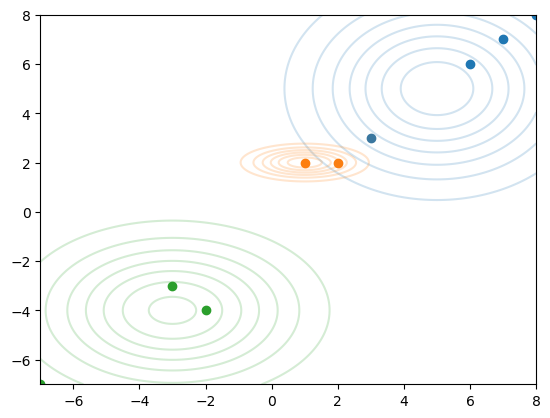

In [14]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

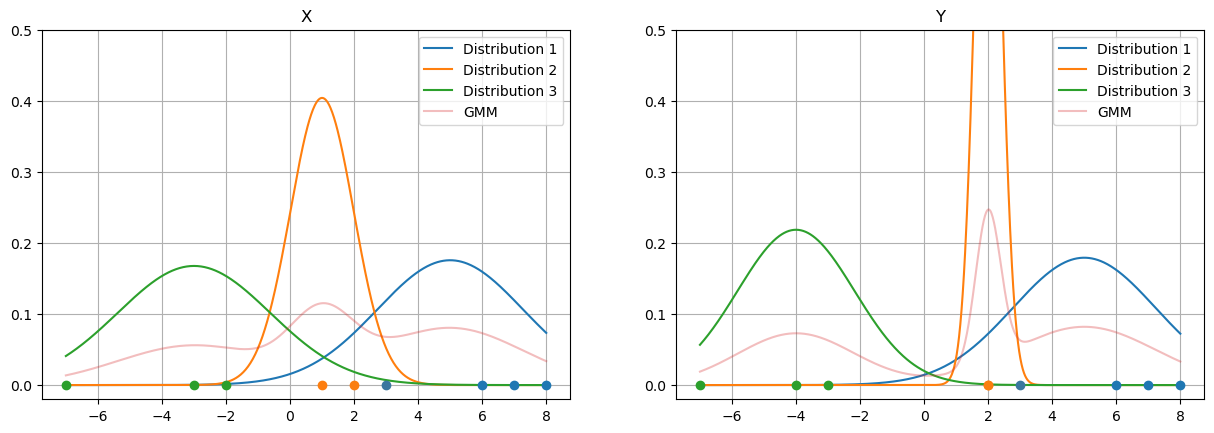

In [15]:
gmm_proj_plot(data_1,mean,cov,m,res = 800)

##### **2nd Iteration**

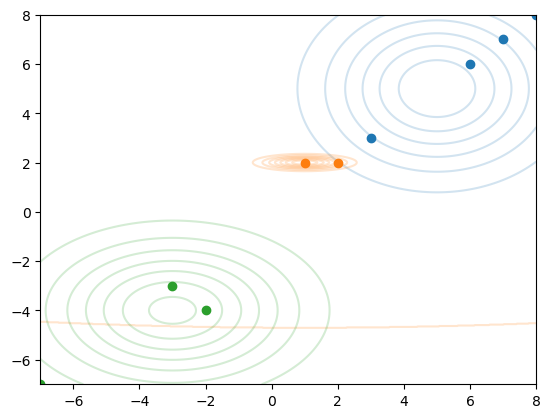

In [16]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

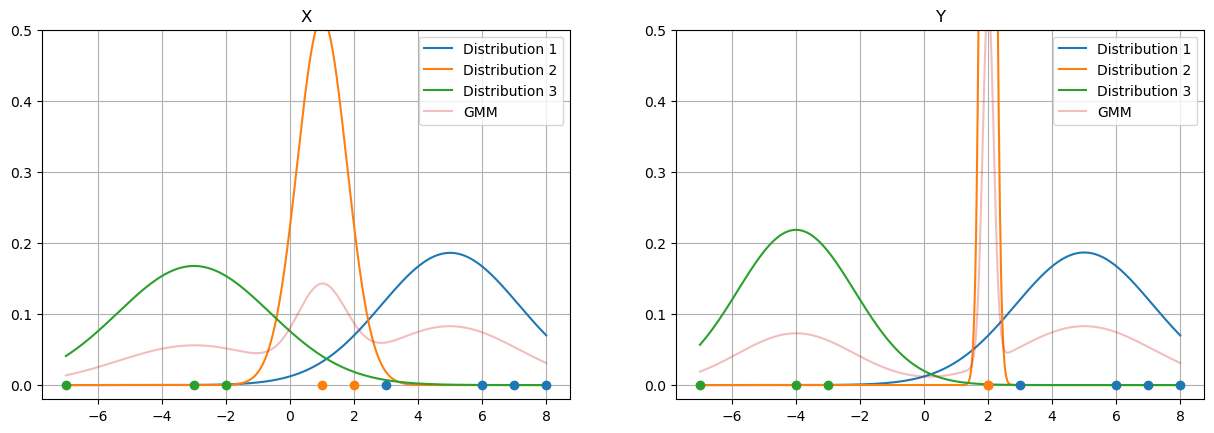

In [17]:
gmm_proj_plot(data_1,mean,cov,m,res = 800)

##### **3rd Iteration**

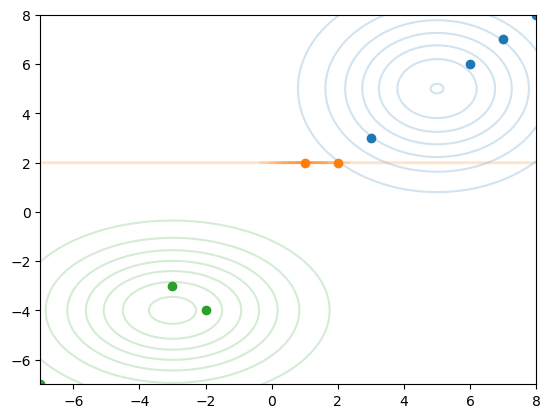

In [18]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

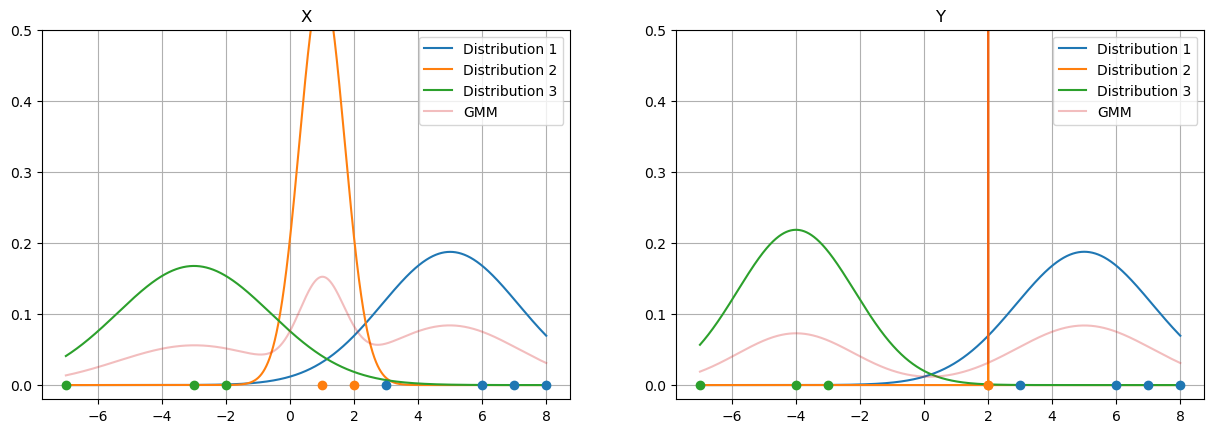

In [19]:
gmm_proj_plot(data_1,mean,cov,m,res = 8000)

#### **Conclusion**

Although the issue of linear correlation found by the blue distribution in the standard EM algorithm has been addressed by restricting distributions to spread parallel to the feature axes, the covariance matrix still becomes singular. This occurs because the orange cluster contains only two data points that are identical in the Y feature.

### 2. Plot  the log  likelihood  of the  model given the  data  after  each  EM  step.  In  other  words,  plot $log\prod_nP(\vec{x}_n;\vec{\mu},\bold\Sigma) $. Does it goes up every iteration just as we learned in class?

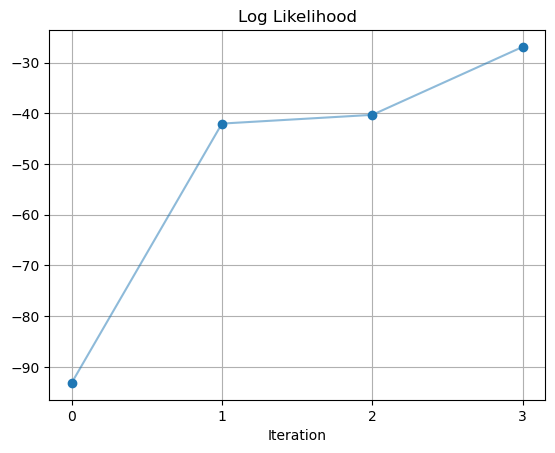

In [20]:
n_iteration = 3 # the number of iterations

# -- |Parameters Re-Initialization| --
m = np.full(3, 1/3)                         # Mixture weight [size: K]
mean = np.array([[3,3],[2,2],[-3,-3]])      # Mean [size: K x D]
cov = np.full((3,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

# -- |Likelihood Function| --
def gmm(data, mean, cov, m):
    '''Return the likelihood of the GMM according to given parameters.'''
    l = 1
    for n in range(data_1.shape[1]):
        L = 0
        for j in range(len(mean)):
            L += multivariate_normal(data.T[n], mean[j], cov[j])*m[j] 
        l *= L
    return l

# -- |Log Likelihood Calculation over Iterations| --
l_history_3 = []
l_history_3.append(np.log(gmm(data_1,mean,cov,m)))

for i in range(n_iteration):
    one_EM_iteration_diag_cov()
    l_history_3.append(np.log(gmm(data_1,mean,cov,m)))

plt.plot(range(n_iteration + 1), l_history_3, alpha = 0.5)
plt.plot(range(n_iteration + 1), l_history_3, 'o', color=colors[0])
plt.title('Log Likelihood')
plt.xticks(range(n_iteration + 1))
plt.xlabel('Iteration')
plt.grid(True)

plt.show()

The log-likelihood increases with each iteration as the maximization steps aim to maximize the ELBO given the weights, and the weights are updated based on the parameters from the maximization step. Theoretically, the model's performance should improve over iterations until it converges to a certain value. However, in this case, the occurrence of a singular covariance matrix prevents other distributions from converging.

### 3. Using  2  mixtures,  initialize  your  Gaussian  with  means  (3,3),  and  (3,-3),  and  standard Covariance,  $I$,  the  identity  matrix. Use  equal  mixture  weights  as  the  initial  weights.  Repeat  three iterations of EM. Write down $w_{n,j}$, $m_j$, $\vec{\mu}_j$, $\bold\Sigma_j$ and plot the likelihood distributions (2 Gaussians) of each feature for each EM iteration.

#### Initial Parameters

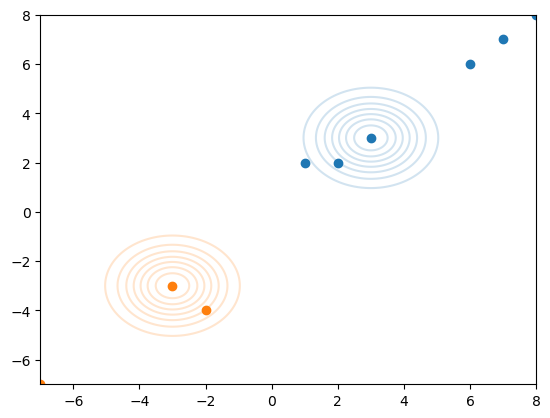

In [21]:
# -- |Parameters Initialization| --
m = np.full(2, 1/2)                         # Mixture weight [size: K]
mean = np.array([[3,3],[-3,-3]])            # Mean [size: K x D]
cov = np.full((2,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

gmm_contour_plot(data_1,mean,cov,res = 800)

#### **1st Iteration**

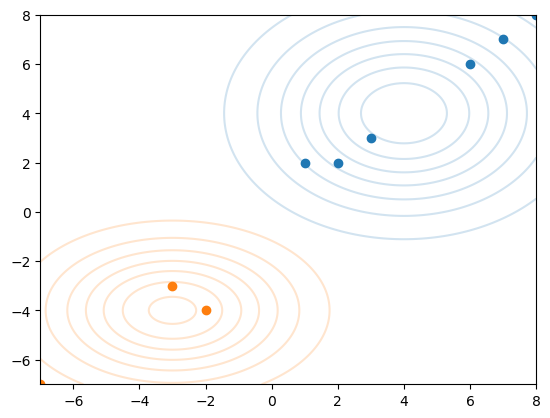

In [22]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

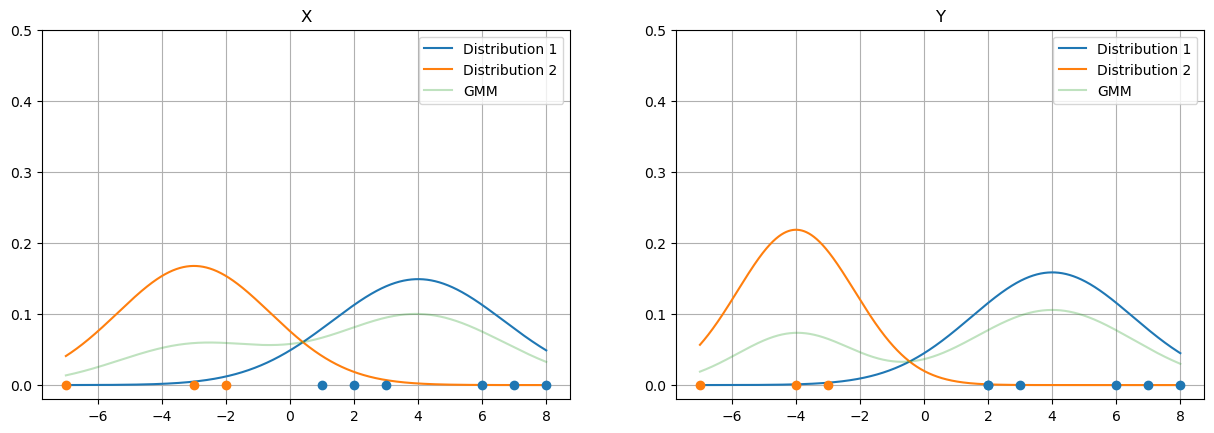

In [23]:
gmm_proj_plot(data_1,mean,cov,m,res = 8000)

#### **2nd Iteration**

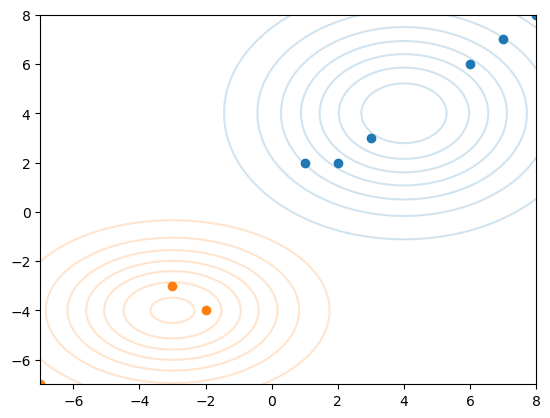

In [24]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

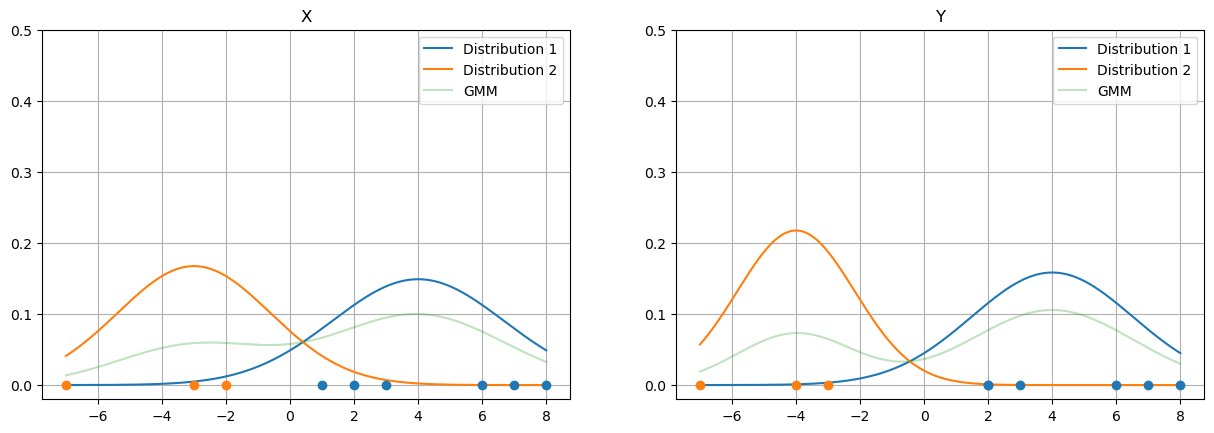

In [25]:
gmm_proj_plot(data_1,mean,cov,m,res = 8000)

#### **3rd Iteration**

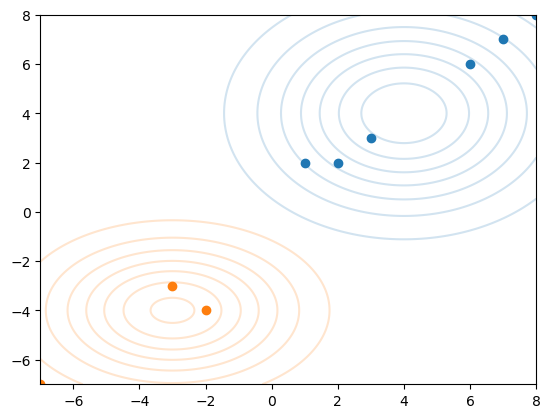

In [26]:
one_EM_iteration_diag_cov()
gmm_contour_plot(data_1,mean,cov,res = 800)

**Likelihood Distribution of Each Feature**

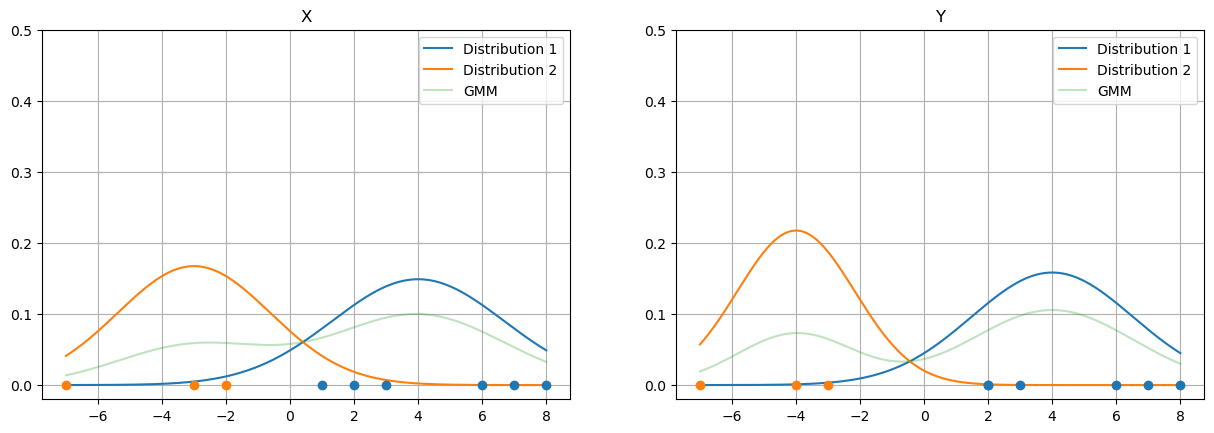

In [27]:
gmm_proj_plot(data_1,mean,cov,m,res = 8000)

#### **Conclusion**
By implementing the EM algorithm (using only the diagonal elements of the covariance matrices) with only two mixtures, the results converged by the first iteration, as seen from the fact that the results from the second and third iterations did not significantly differ from the first iteration. The main reason for this rapid convergence is attributed to effective initialization, particularly the means of both distributions, which were already close to the local minimum from the start. This indicates that careful initialization of parameters can significantly influence the efficiency and speed of convergence in the EM algorithm.

### 4. Plot  the  log  likelihood  of  the  model  given  the  data  after  each  EM  step.  Compare  the  log likelihood  between using two  mixtures  and three mixtures.  Which  one has  the better  likelihood?

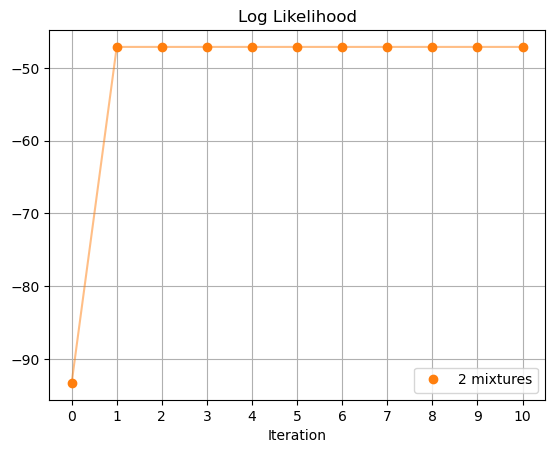

In [28]:
n_iteration = 10 # the number of iterations

# -- |Parameters Re-Initialization| --
m = np.full(2, 1/2)                         # Mixture weight [size: K]
mean = np.array([[3,3],[-3,-3]])            # Mean [size: K x D]
cov = np.full((2,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

# -- |Log Likelihood Calculation over Iterations| --
l_history_2 = []
l_history_2.append(np.log(gmm(data_1,mean,cov,m)))

for i in range(n_iteration):
    one_EM_iteration_diag_cov()
    l_history_2.append(np.log(gmm(data_1,mean,cov,m)))

plt.plot(range(n_iteration + 1), l_history_2, alpha = 0.5, color=colors[1])
plt.plot(range(n_iteration + 1), l_history_2, 'o', color=colors[1], label='2 mixtures')
plt.title('Log Likelihood')
plt.xticks(range(n_iteration + 1))
plt.xlabel('Iteration')
plt.grid(True)
plt.legend()

plt.show()

This graph suggested that the model actually converged at the first iteration.

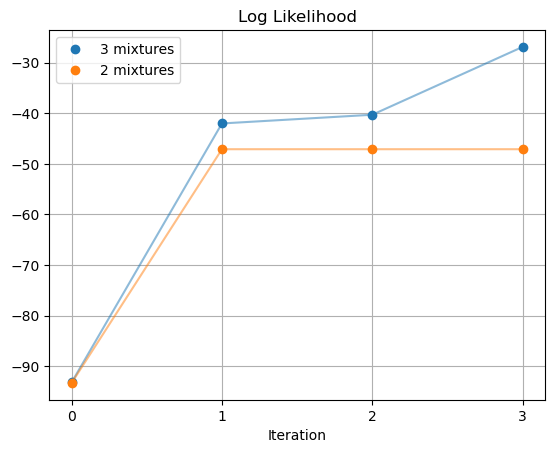

In [29]:
n_iteration = 3 # the number of iterations

# -- |Parameters Re-Initialization| --
m = np.full(2, 1/2)                         # Mixture weight [size: K]
mean = np.array([[3,3],[-3,-3]])            # Mean [size: K x D]
cov = np.full((2,2,2),np.identity(2))       # Covariance matrix [size: K x D x D]

plt.plot(range(n_iteration + 1), l_history_3, alpha = 0.5)
plt.plot(range(n_iteration + 1), l_history_3, 'o', color=colors[0], label='3 mixtures')

# -- |Log Likelihood Calculation over Iterations| --
l_history_2 = []
l_history_2.append(np.log(gmm(data_1,mean,cov,m)))

for i in range(n_iteration):
    one_EM_iteration_diag_cov()
    l_history_2.append(np.log(gmm(data_1,mean,cov,m)))

plt.plot(range(n_iteration + 1), l_history_2, alpha = 0.5, color=colors[1])
plt.plot(range(n_iteration + 1), l_history_2, 'o', color=colors[1], label='2 mixtures')
plt.title('Log Likelihood')
plt.xticks(range(n_iteration + 1))
plt.xlabel('Iteration')
plt.grid(True)
plt.legend()

plt.show()

As demonstrated in the graph, the EM algorithm with three mixtures achieved a higher log-likelihood than the EM with only two mixtures. This illustrates the principle that a higher number of mixtures reduces the model's bias, thereby increasing its likelihood. However, this comes at the cost of increased model variance, which can lead to overfitting. This trade-off highlights the importance of selecting an appropriate number of mixtures to balance model accuracy and generalizability. 

However, the results would be better demonstrated if implemented on a larger dataset, as the convergence of the three-mixture EM is not confirmed due to the occurrence of a singular matrix, which makes further demonstration impossible. A larger dataset might provide a more robust evaluation of the model's performance and its ability to converge without encountering issues such as singular covariance matrices.

## **Chapter 2: Face verification system by Principal Component Analysis (PCA)**

### **The face database**
For this homework we will work on face verification (Given a face, say whether it is person A or not). 
Face verification is quite related to face recognition (Given a face, say who it is). Face verification is a 
binary classification task, while face recognition is a multi-class problem. 
Download the file “facedata.mat”. You can load the data by 

In [30]:
import  scipy.io 
data = scipy.io.loadmat('facedata.mat') 

Data is a dictionary with key value pairs. The data you want to use can be accessed by using ‘facedata’ 
as the key. 

In [31]:
# face data is a 2-dimensional array with size 40x10 
print(data['facedata'].shape)

(40, 10)


Each data is indexed by $i$ and $j$ where $i$ is the person index $j$ is the index of the pose In other words, there are 40 people in the database. There are 10 images per person. 

In [32]:
print(data['facedata'][0,0])

[[48 46 50 ... 50 54 53]
 [47 47 48 ... 37 46 50]
 [46 48 43 ... 33 41 51]
 ...
 [49 49 50 ... 45 46 47]
 [48 48 49 ... 45 46 46]
 [51 48 50 ... 45 45 46]]


Each image is a 56 by 46 pixels

In [33]:
print(data['facedata'][0,0].shape)

(56, 46)


You can see the image by using the imshow in matplotlib

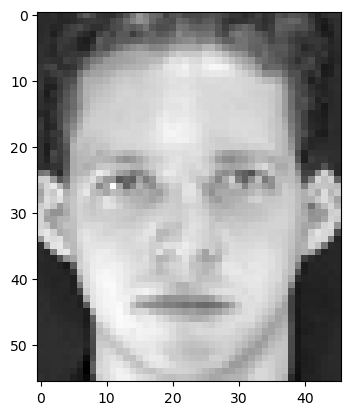

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
plt.imshow(data['facedata'][0,0],cmap="gray") 
plt.show()

### **Working with images**
Each pixel in an image is usually represented by a 8-bit unsigned integer (values from 0 to 255). In 
order  to  easily  work  on  images,  we  usually  convert  them  to  floats  or  doubles  using  the  following 
command.

In [35]:
from skimage import img_as_float 
xf = {} 
xf[0,0] = img_as_float(data['facedata'][0,0]) 
print(xf[0,0])

[[0.18823529 0.18039216 0.19607843 ... 0.19607843 0.21176471 0.20784314]
 [0.18431373 0.18431373 0.18823529 ... 0.14509804 0.18039216 0.19607843]
 [0.18039216 0.18823529 0.16862745 ... 0.12941176 0.16078431 0.2       ]
 ...
 [0.19215686 0.19215686 0.19607843 ... 0.17647059 0.18039216 0.18431373]
 [0.18823529 0.18823529 0.19215686 ... 0.17647059 0.18039216 0.18039216]
 [0.2        0.18823529 0.19607843 ... 0.17647059 0.17647059 0.18039216]]


“img_as_float” scales 0-255 to 0-1. You can still show the image using the same “imshow” command. 

Note that the index of a 2D image starts from the upper left corner of the image. The first dimension 
goes downwards, while the second dimension goes to the right (think of it as a matrix). To understand 
what this means, try the following code.

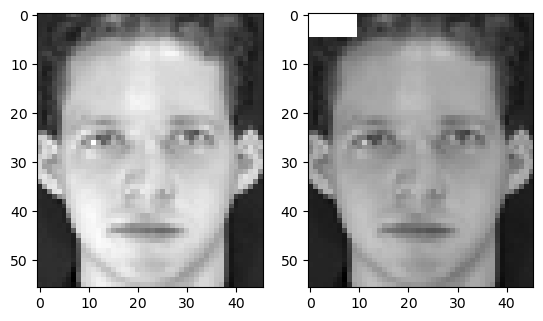

In [36]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(xf[0,0],cmap="gray") 
x_temp = xf[0,0].copy() 
x_temp[0:5,0:10] = 1 
# In float format, 1 is white  
ax[1].imshow(x_temp,cmap="gray") 
plt.show()

### **The similarity matrix**
Consider a set of $N$ data points, a similarity matrix $\bold{S}$ is a matrix where $\bold{S}_{i,j}$ is the distance between 
the ith and the jth data point. A similarity  matrix can be very useful for analyzing the data and its 
distribution. Since a similarity matrix can also be considered as an image, you can also show it as an 
image to see the pattern in the data. 
But how do we define similarity? How can we quantify whether image A is closer to B than image C? 
 
One  way  is  to  treat  each  pixel  in  image  as  an  element  in  a  vector  (you  may  find  the  function 
`numpy.reshape()` useful). Then, compare the two vectors using Euclidean distance. 
Euclidean distance between vector 𝑥 and 𝑦 is defined as:
$$D_{Euclidian}=\sqrt{\sum_d(x_d-y_d)^2}$$
where $d$ refers to the index of the dimension.

### 1. What is the Euclidean distance between xf[0,0] and xf[0,1]? What is the Euclidean distance between xf[0,0] and xf[1,0]? Does the numbers make sense? Do you think these numbers will be useful for face verification? Why?

In [37]:
def similarity(A, B):
    '''Calculate the similarity between matrix A and B using the Euclidean distance.'''
    return np.sqrt(np.sum((A.reshape(-1) - B.reshape(-1))**2))

In [38]:
# -- |Define the Dataset Dictionary (xf)| --
# Indices
i, j = np.mgrid[:40, :10]
ind = list(zip(i.reshape(-1),j.reshape(-1)))

# Float image
float_img = [img_as_float(face) for face in data['facedata'].reshape(1,-1)[0]]

xf = dict(zip(ind,float_img))

# -- |Display Calculated EUclidean Distance| --
print(f'The euclidean distance between xf[0,0] and xf[0,1] is {similarity(xf[0,0],xf[0,1])}')
print(f'The euclidean distance between xf[0,0] and xf[1,0] is {similarity(xf[0,0],xf[1,0])}')

The euclidean distance between xf[0,0] and xf[0,1] is 10.037616294165492
The euclidean distance between xf[0,0] and xf[1,0] is 8.173295099737281


As we continue our exercise, we will refine our feature vectors so that the Euclidean distance between two images can be used in a face verification system. We define the similarity matrix, $𝐴$, as a matrix whose elements $𝐴_{𝑖,𝑗}$ is the Euclidean distance between data sample $𝑖$ from list $𝑇$ and data sample $𝑗$ from list $𝐷$, where list $𝑇$, $𝐷$ are lists of data samples. 

### 2. Write a function that takes in a set of feature vectors $T$ and a set of feature vectors $D$, and then output the similarity matrix $A$. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people for list $𝑇$ (in order x[0, 0], x[0, 1], x[0, 2], x[1, 0], x[1, 1], ...x[39, 2]). Use the feature vectors from the remaining 7 images from all 40 people for list $D$ (in order x[0, 3], x[0, 4], x[0, 5], x[1, 6], x[0, 7], x[0, 8], x[0, 9], x[1, 3], x[1, 4]...x[39, 9]). We will treat $T$ as our training images and $D$ as our testing images.

In [39]:
def similarity_matrix(A, B):
    '''Calculate similarity matrix given feature vector A and B.'''
    S = []
    for a in A:
        S_i = []
        for b in B:
            S_i.append(similarity(a,b))
        S.append(S_i)
    return np.array(S)

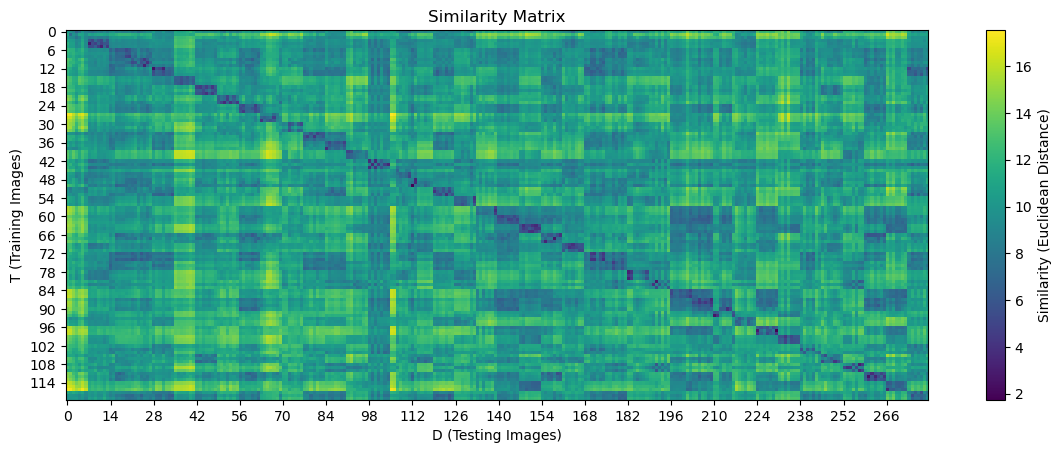

In [40]:
# -- |Train and Test Image Initialization| --
# Train images
i, j = np.mgrid[:40, :3]
T_ind = list(zip(i.reshape(-1),j.reshape(-1)))
T = [xf.get(key) for key in T_ind]
# Test images
i, j = np.mgrid[0:40, 3:10]
D_ind = list(zip(i.reshape(-1),j.reshape(-1)))
D = [xf.get(key) for key in D_ind]

# -- |Similarity Matrix Calculation| --
A = similarity_matrix(T,D)

# -- |Display| --
fig, ax = plt.subplots()
ax.set_xlabel('D (Testing Images)')
ax.set_ylabel('T (Training Images)')
ax.set_xticks(range(0,A.shape[1],14))
ax.set_yticks(range(0,A.shape[0],6))
ax.set_title('Similarity Matrix')

fig.set_figwidth(15)
im = ax.imshow(A)
fig.colorbar(im, orientation='vertical', label='Similarity (Euclidean Distance)')
plt.show()

In our simple face verification system,  given a test image, we want to test if that image comes from 
person A or not. We will compare the test image against the three training images from person A we 
have. If the minimum distance (between the three training images) is below a threshold, 𝑡, we say that 
the test image is person A.

### 3. Write  a  function  that  takes  in  the  similarity  matrix  created  from  the  previous  part,  and  a threshold $t$ as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task (280 Test images, tested on 40 people). What is the true positive rate and the false alarm rate for $t$ = 10?

#### Function Definition

In [59]:
def verification(A, threshold, train_per_person = 3):
    B = A < threshold

    verification_results = []
    for j in range(B.shape[1]):
        test_element_results = []
        for i in range(0,B.shape[0],train_per_person):
            # test_element_results.append(sum(B[i:i+train_per_person,j]) > (train_per_person/2))
            test_element_results.append(sum(B[i:i+train_per_person,j]) > (0))
        verification_results.append(test_element_results)

    return np.array(verification_results)

def verification_performance(verification_results, test_per_person = 7):
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    for i in range(verification_results.shape[1]):
        person_i = verification_results[:,i]
        for j in range(verification_results.shape[0]):
            if j in list(range(test_per_person*i, test_per_person*i+test_per_person)):
                if person_i[j]:
                    TP += 1
                else:
                    FN += 1
            else:
                if person_i[j]:
                    FP += 1
                else:
                    TN += 1
            
    return (TP, FN, FP, TN)

def confusion_matrix(TP,FN,FP,TN):
    # -- |Results calculation| --
    accuracy = (TP + TN)/(TP + FP + TN + FN)

    if TP + FP == 0:
        precision = np.NaN
    else:
        precision = TP/(TP + FP)
    
    if TP + FN == 0:
        recall = np.NaN
    else:
        recall = TP/(TP + FN)
        
    f1 = 2*(precision*recall)/(precision + recall)

    # -- |Results display| --
    print('Confusion Matrix')
    print('--------------------------------------')
    print('|            |       Predicted       |')
    print('|            -------------------------   Accuracy  = {0:}'.format(accuracy))
    print('|            |     P     |     N     |')
    print('--------------------------------------   Precision = {0:}'.format(precision))
    print("|        | P |   {0:^5d}   |   {1:^5d}   |   Recall    = {2:}".format(TP, FN, recall))
    print('| Actual -----------------------------')
    print("|        | N |   {0:^5d}   |   {1:^5d}   |   F1-score  = {2:}".format(FP, TN, f1))
    print('--------------------------------------')

    return [accuracy, precision, recall, f1]

#### Results

In [60]:
# -- |Hyperparameter| --
t = 10

# -- |Verification Test Images| --
verification_results = verification(A, t)

# -- |Verification Performance| --
TP, FN, FP, TN = verification_performance(verification_results)
accuracy, precision, recall, f1 = confusion_matrix(TP, FN, FP, TN)
print('True  positive rate:', TP/(TP + FN))
print('False positive rate:', FP/(FP + TN))

Confusion Matrix
--------------------------------------
|            |       Predicted       |
|            -------------------------   Accuracy  = 0.5549107142857143
|            |     P     |     N     |
--------------------------------------   Precision = 0.053011590347710434
|        | P |    279    |     1     |   Recall    = 0.9964285714285714
| Actual -----------------------------
|        | N |   4984    |   5936    |   F1-score  = 0.10066750856936678
--------------------------------------
True  positive rate: 0.9964285714285714
False positive rate: 0.4564102564102564


### 4. Plot  the RoC curve (curve between the true positive  rate  (TP)  as  y-axis  and the false  alarm rate (false positive rate or FP) as x-axis) for this simple verification system when threshold changes. What  should  be the  minimum  threshold  to  generate the RoC  curve?  What  should  be  the maximum threshold? Your RoC should be generated from at least 1000 threshold levels equally spaced between the minimum and the maximum. (You should write a function for this).

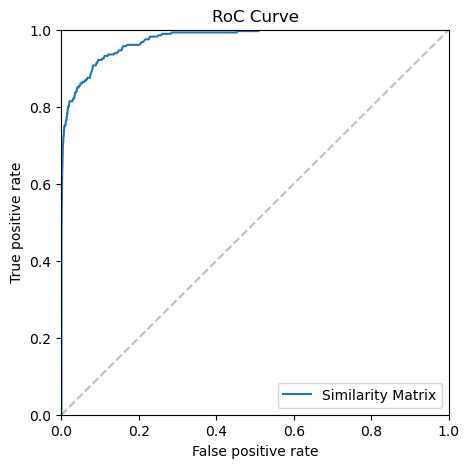

Optimal threshold: 8.091949171960042 ; TPR = 0.9107142857142857 , FPR = 0.08983516483516484


In [61]:
tol = 0.005
thresholds = np.linspace(np.min(A),np.max(A),1000)

# -- |RoC Curve Calculation| --
TPR = []
FPR = []
opt = {}
for t in thresholds:
    # -- |Verification Test Images| --
    verification_results = verification(A, t)

    # -- |Verification Performance| --
    TP, FN, FP, TN = verification_performance(verification_results)

    # -- |TPR and FPR Calculation| --
    tpr = TP/(TP + FN)
    fpr = FP/(FP + TN)
    TPR.append(tpr)
    FPR.append(fpr)

    if 1 - tol < tpr + fpr and tpr + fpr < 1 + tol:
        opt[t] = (fpr,tpr)

# -- |Optimal Threshold Performance| --
t_opt = np.median(list(opt.keys()))
verification_results = verification(A, t_opt)
TP, FN, FP, TN = verification_performance(verification_results)

tpr_opt = TP/(TP + FN)
fpr_opt = FP/(FP + TN)

# -- |RoC Curve Display| --
fig, ax = plt.subplots()
ax.set_title('RoC Curve')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

fig.set_figwidth(5)
fig.set_figheight(5)
ax.plot(FPR,TPR, label='Similarity Matrix')
ax.plot([0,1],[0,1],'--',color='grey',alpha=0.5)
ax.legend()
plt.show()
print('Optimal threshold:', t_opt, '; TPR =', tpr_opt, ', FPR =', fpr_opt)

### **Principle Component Analysis (PCA)**
PCA  is  a  method  for  dimensionality  reduction  that  is  very  flexible  and  fits  many  use  cases.  It  is 
unsupervised (needs no class  label).  The core of PCA  is  using eigendecomposition  to  decompose the 
data into the directions of maximum variance. 

Let’s define a matrix $X$ with each column as an input sample $\vec{x}_i$. 
A typical PCA starts  by normalizing each feature dimension so that they have equal range. For our 
case, since our input vectors are already between 0 and 1, we can skip this step. 
The first step of PCA is to first remove the global mean from our data. Let $\vec{\mu}_x$ be the means of the input 
data along each input dimension. Let $\hat{X}$ be the matrix with the mean of the input samples removed. 
Be sure to use the mean computed from just the training examples. 

### 5. Compute  the  mean  vector  from  the  training  images.  Show  the  vector  as  an  image  (use `numpy.reshape()`). This is typically called the meanface (or meanvoice for speech signals). And plot the meanface by `imshow` command.

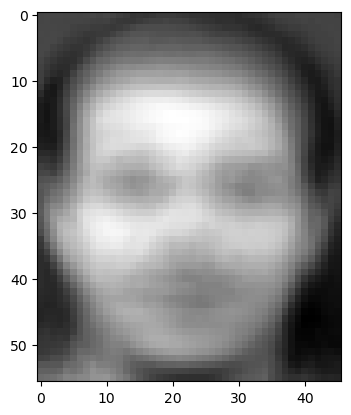

In [44]:
# -- |Meanface Calculation| --
sumface = np.zeros((56,46))
for face in T:
    sumface += face
meanface = sumface/len(T)

plt.imshow(meanface, cmap='grey')
plt.show()

In [45]:
# -- |Remove Meanface from Train set| --
T_hat = (np.array(T) - meanface).reshape((120,-1)).T # matrix T with each column as an input sample
print('Training set shape:',T_hat.shape , '[#feature x #sample]')

Training set shape: (2576, 120) [#feature x #sample]


We can then compute eigenvectors on the covariance matrix computed from  $\hat{X}$. The PCA vectors would 
correspond to the eigenvectors, $\vec{v}$. In other words, $\bold\Sigma\vec{v} = \lambda\vec{v}$. 
However, if we compute the covariance matrix, we would need a lot of space to store it.

### 6. What is the size of the covariance matrix? What is the rank of the covariance matrix? 

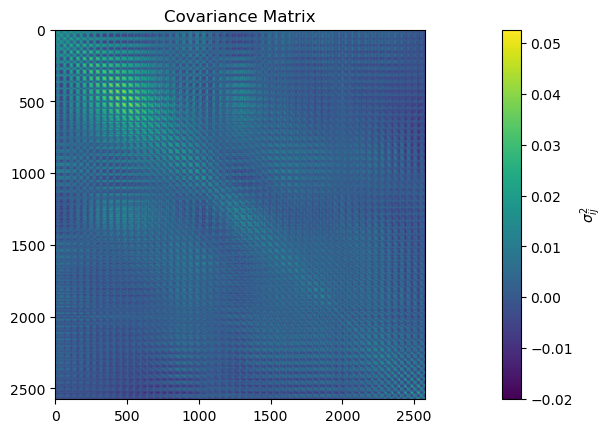

Covariance matrix size: (2576, 2576)
Covariance matrix rank: 119


In [46]:
cov = (T_hat @ T_hat.T)/(T_hat.shape[1])

# -- |Display| --
fig, ax = plt.subplots()
ax.set_title('Covariance Matrix')
fig.set_figwidth(20)
im = ax.imshow(cov)
fig.colorbar(im, orientation='vertical', label='$\sigma^2_{ij}$')
plt.show()

print('Covariance matrix size:', cov.shape)
print('Covariance matrix rank:', np.linalg.matrix_rank(cov))

The trick is to compute the Gram Matrix ($\hat{X}^T\hat{X}$), which is the inner product between the input matrices.

### 7. What  is  the size  of the Gram  matrix?  What  is  the rank  of Gram  matrix?  If we compute the eigenvalues from the Gram matrix, how many non- zero eigenvalues do we expect to get?

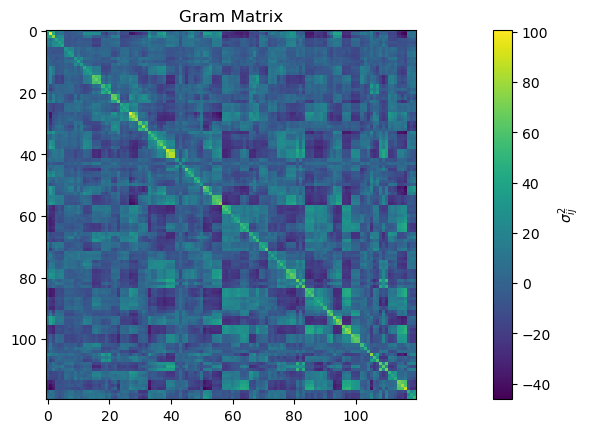

Gram matrix size: (120, 120)
Gram matrix rank: 119
119 non-zero eigenvalues are expected to get


In [47]:
gram = (T_hat.T @ T_hat)

# -- |Display| --
fig, ax = plt.subplots()
ax.set_title('Gram Matrix')
fig.set_figwidth(20)
im = ax.imshow(gram)
fig.colorbar(im, orientation='vertical', label='$\sigma^2_{ij}$')
plt.show()

print('Gram matrix size:', gram.shape)
print('Gram matrix rank:', np.linalg.matrix_rank(gram))
print(f'{np.linalg.matrix_rank(gram)} non-zero eigenvalues are expected to get')

### 8. Is the Gram matrix also symmetric? Why? 

Because Gram matrix can also be seen as the inner product of matrix as well as covariance matrix.

Using the gram matrix, we instead solve for the eigenvector, $\vec{v'}$.
$$\hat{X}^T\hat{X}\vec{v'}=\lambda\vec{v'}$$
where  the  desired  eigenvector  (eigenvector  of  the  covariance  matrix)  can  be  computed  from  $\vec{v'}$ 
(eigenvector of the gram matrix) using the following relationship 
$$\vec{v}=\hat{X}\vec{v'}$$
In order to compute the eigenvectors and eigenvalues, we can use the function `numpy.linalg.eigh` 
which can be used on symmetric matrices. For symmetric matrices, the eigenvectors and eigenvalues 
will  always  be  real.  In  contrast,  if  the  matrix  is  not  symmetric,  we  have  to  use  the  function 
`numpy.linalg.eig` which will output complex numbers. 

### 9. Compute the eigenvectors and eigenvalues of the Gram matrix,  $\vec{v'}$ and $\lambda$. Sort the eigenvalues and  eigenvectors  in  descending  order  so  that  the  first  eigenvalue  is  the  highest,  and  the  first eigenvector corresponds to the best direction. How many non-zero eigenvalues are there? If you see a very small value, it is just numerical error and should be treated as zero. 

In [48]:
# -- |Calculate Eigenvalues and Eigenvectors for Gram Matrix| --
gram_eigval, gram_eigvec = np.linalg.eigh(gram)

# -- |Sort in Descendent Order| --
gram_eigval = np.array(list(reversed(gram_eigval)))
gram_eigvec = np.array(list(reversed(gram_eigvec)))

eps = 10**-10   # Determine the small number which will be considered as zero
print(f'Number of non-zero eigenvalues: {sum(gram_eigval > eps)}')

Number of non-zero eigenvalues: 119


### 10.  Plot the eigenvalues. Observe how fast the eigenvalues decrease. In class, we learned that the eigenvalues  are  the size  of the variance for each eigenvector direction. If I  want to keep 95%  of the variance in the data, how many eigenvectors should I use?

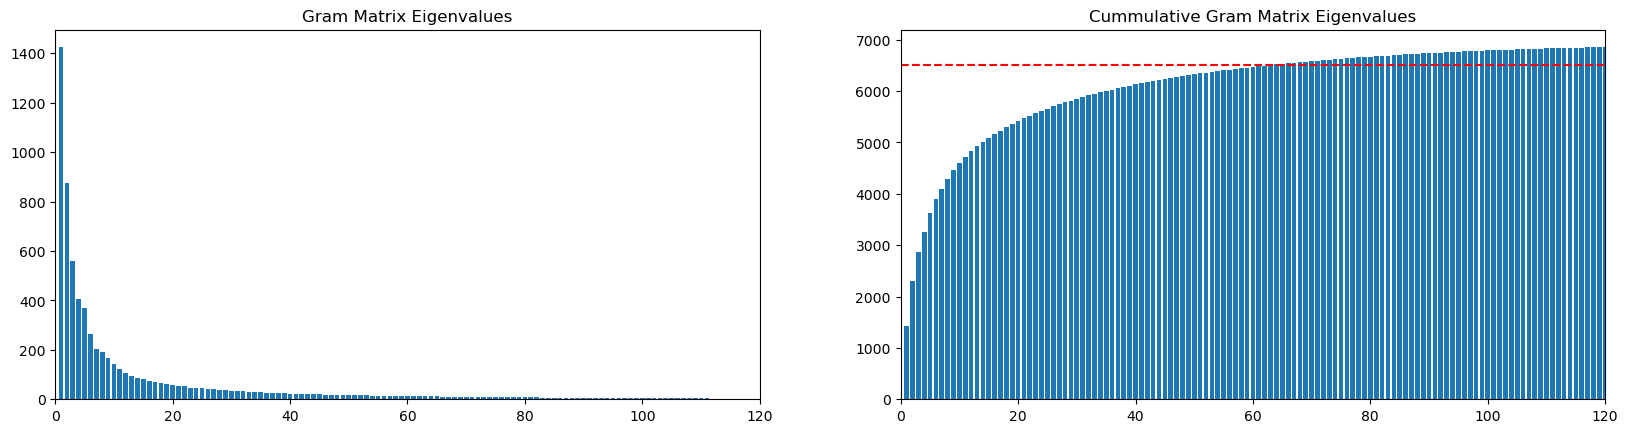

We should use 64 eigenvectors to keep 95% of the data variance


In [49]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# -- |Eigenvalues Plot| --
ax[0].set_title('Gram Matrix Eigenvalues')
ax[0].bar(list(range(1, gram_eigval.shape[0]+1)), gram_eigval)
ax[0].set_xlim(0,gram_eigval.shape[0])

# -- |Cummulative Eigenvalues Plot| --
ax[1].set_title('Cummulative Gram Matrix Eigenvalues')
ax[1].bar(list(range(1, gram_eigval.shape[0]+1)), np.cumsum(gram_eigval))
ax[1].axhline(y=0.95*np.sum(gram_eigval), color='red', linestyle='--')
ax[1].set_xlim(0,gram_eigval.shape[0])
plt.show()

# -- |Solve Optimal Amount of Eigenvector| --
cumsum = 0
for i in range(gram_eigval.shape[0]):
    cumsum += gram_eigval[i]
    if cumsum >= 0.95*np.sum(gram_eigval):
        lasted_selected_comp = i
        break

print(f'We should use {i+1} eigenvectors to keep 95% of the data variance')


### 11.  Compute  $\vec{v}$ and  show  the  first  10  eigenvectors  as  images  of  the  original $\vec{v}$ and  $\vec{v}$ taking renormalize  and  show  the  norm  of  each  vector.  Two  example  eigenvectors  are  shown  below.  We  call these images eigenfaces (or eigenvoice for speech signals).

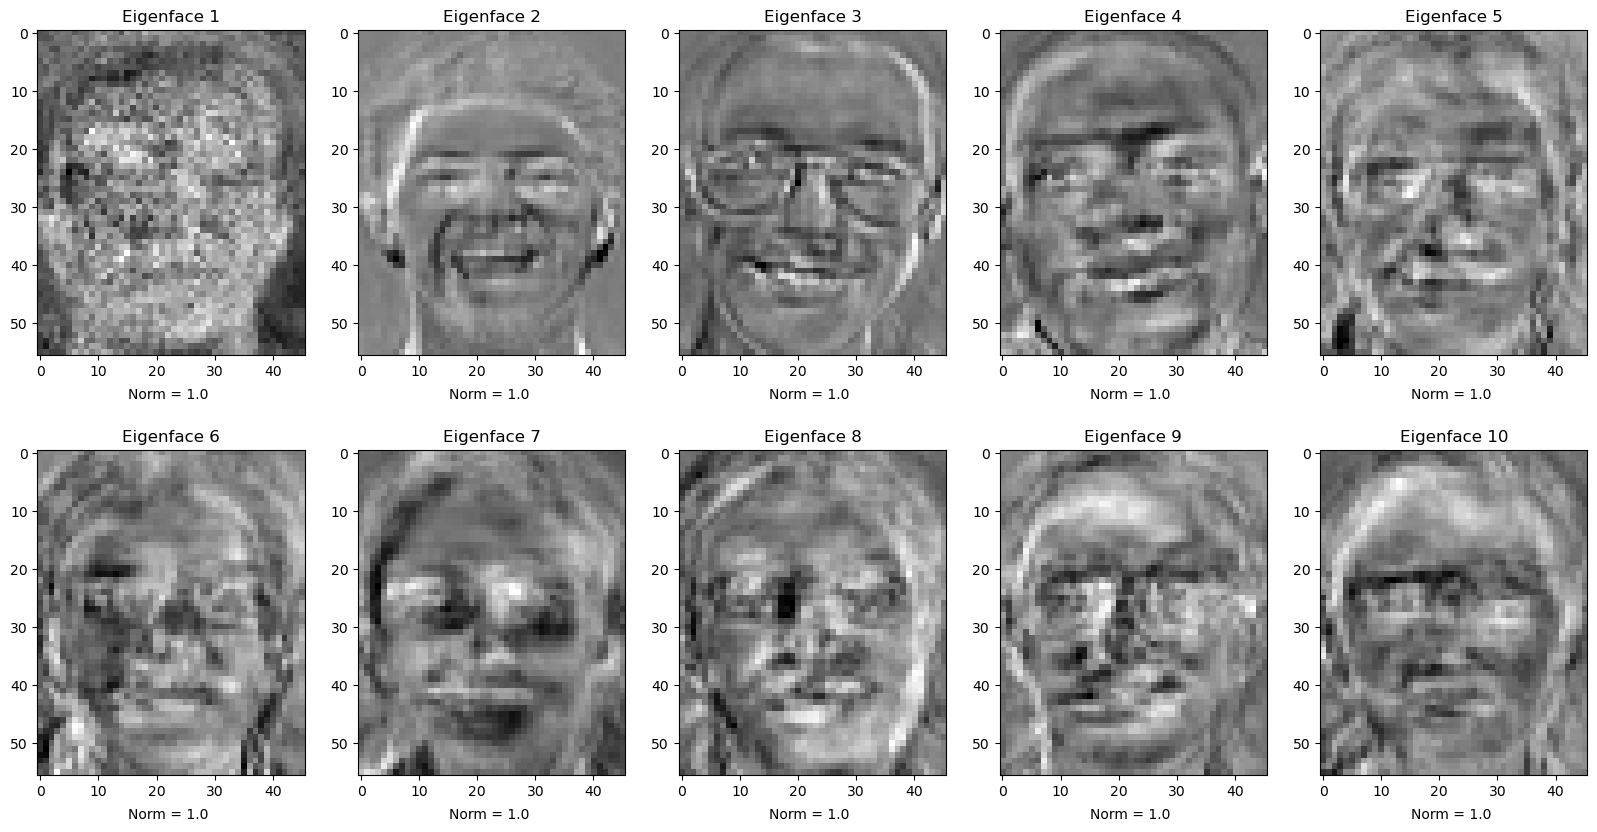

In [50]:
cov_eigvec = T_hat @ gram_eigvec
eigenface = cov_eigvec.T.reshape(-1,56,46)

# -- |Renormalization| --
eigenface = np.array([face/np.linalg.norm(face) for face in eigenface])
cov_eigvec = eigenface.reshape(120,-1).T

eigenface_norm = np.array([np.linalg.norm(face) for face in eigenface])

# -- |Eigenface Display| --
ny = 2
nx = 5
fig, ax = plt.subplots(ny,nx)
fig.set_figwidth(nx*4)
fig.set_figheight(ny*5)
ax = ax.reshape(-1)
for i in range(nx*ny):
    ax[i].imshow(eigenface[i],cmap='gray')
    ax[i].set_title(f'Eigenface {i+1}')
    ax[i].text(22, 63, f'Norm = {eigenface_norm[i]:.5}', fontsize=10, horizontalalignment='center')
plt.show()

### 12.  From  the  image,  what  do  you  think  the  first  eigenvector  captures?  What  about  the  second eigenvector?  Look  at  the  original  images,  do  you  think  biggest  variance  are  capture  in  these  two eigenvectors?

### **PCA subspace and the face verification system** 
These eigenfaces we computed serve as good directions to project our data onto in order to decrease 
the number of dimensions. Since we have shown in class that these eigenvectors are orthogonal (and 
we normalized them so that they are orthonormal), we can find the projection, $\vec{p}$, of the data onto the 
eigenface subspace by 
$$\vec{p}=V^T(\vec{x}-\vec{\mu}_x)$$
where $V$ is a matrix whose columns are the eigenvectors, $\vec{v}$. The projection values, $\vec{p}$, will serve as 
our new input features.

### 13.  Find the projection values  of all  images.  Keep the first  k =  10 projection values.  Repeat the simple  face  verification  system  (like  item  5  in  CHAPTER02)  we  did  earlier  using  these  projected values.

In [51]:
k = 10
V = cov_eigvec[:,:k]

P = V.T @ (np.array(float_img) - meanface).reshape(400,-1).T
P

array([[ 2.14857263e+00,  2.82687035e-01,  4.54743354e-01, ...,
         2.28633464e-01,  1.83237238e-01, -6.43004441e-01],
       [-3.56507518e-02, -1.19388826e-01,  6.45450609e-01, ...,
        -8.08144186e-01, -2.92454854e-03,  8.61975774e-03],
       [ 9.06314359e-01,  1.68251123e+00,  1.06012447e+00, ...,
         1.62109723e-01,  1.40763925e+00, -3.75708780e-01],
       ...,
       [ 1.58920746e+00,  3.12045515e+00,  1.16487791e+00, ...,
         1.44566559e+00,  2.05859124e+00, -5.93414682e-01],
       [ 3.97172379e-01,  2.57433235e+00,  1.60637115e+00, ...,
        -6.14253022e-02,  2.21568554e+00,  8.13051199e-02],
       [ 1.61213939e+00,  4.34293460e+00,  2.70680581e+00, ...,
         1.52219177e-03,  2.26543733e+00, -4.36984795e-01]])

One of the  usage  for  PCA  is  compression.  Using  the  project values,  we  can  reconstruct  the  original 
image. This can be done by 
$$\vec{x'}=\vec{\mu}_x+V\vec{p}$$
where $\vec{x'}$ is the reconstructed image. 
We can compute the error from such reconstruction by computing the Mean Square Error (MSE) 
$$MSE=\sum^N_{i=1}\frac{1}{N}(x_i-x'_i)^2$$
where $N$ is the dimension of the original input.

### 14.  Reconstruct the first image using this procedure. Use k = 10, what is the MSE?

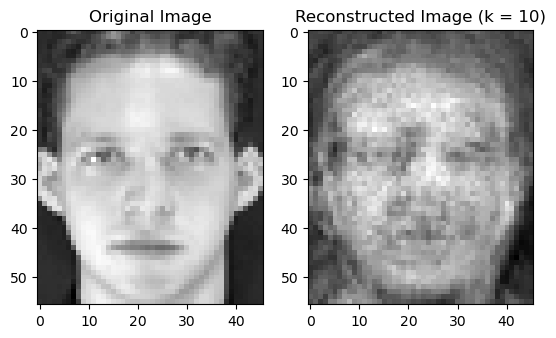

MSE = 0.018963052416013853


In [52]:
x_rec = V @ P[:,0] + meanface.reshape(-1)
x_rec = x_rec.reshape(56,46)

fig, ax = plt.subplots(1,2)
ax[0].set_title('Original Image')
ax[0].imshow(xf[0,0],cmap = 'gray')

ax[1].set_title(f'Reconstructed Image (k = {k})')
ax[1].imshow(x_rec, cmap = 'gray')
plt.show()

MSE = np.sum((xf[0,0] - x_rec)**2)/(xf[0,0].shape[0] * xf[0,0].shape[1])
print('MSE =', MSE)